In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [34]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

dog.jpg exists
torch.Size([3, 1365, 2048])


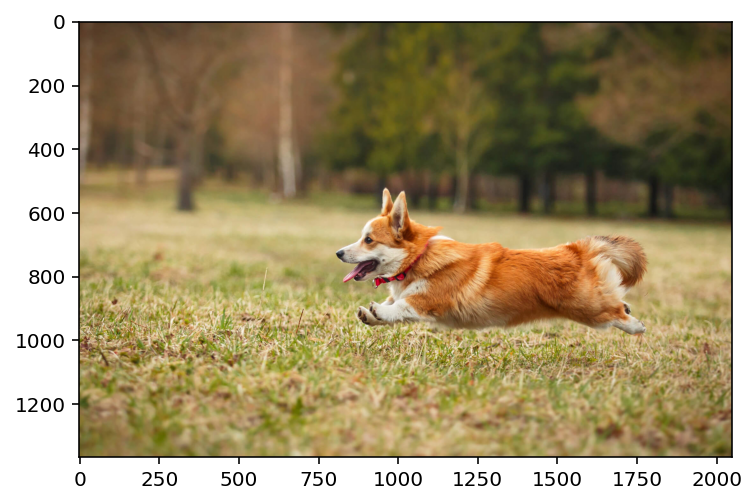

In [35]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [36]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [37]:

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)

In [38]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [57]:
# Crop the image
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

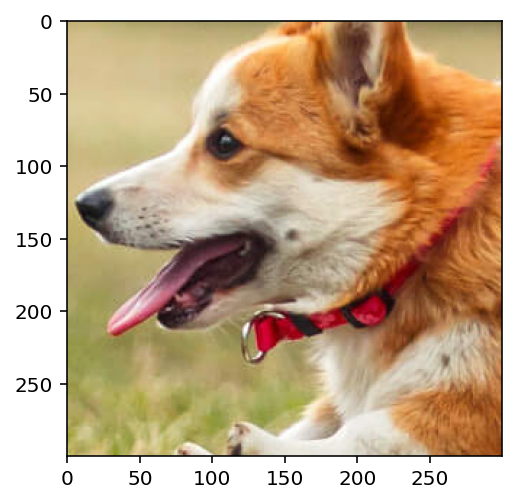

In [58]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [59]:
crop = crop.to(device)

In [60]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
# Define the size of the missing part of the image
patch_size = 50

input_img = []
x_start = [180, 60, 2]
y_start = [80, 20, 2]

for i in range (3):
    x_end, y_end = x_start[i] + patch_size, y_start[i] + patch_size
    img_missing = crop.clone()
    img_missing[:, x_start[i]:x_end, y_start[i]:y_end] = float('nan')
    input_img.append(img_missing)


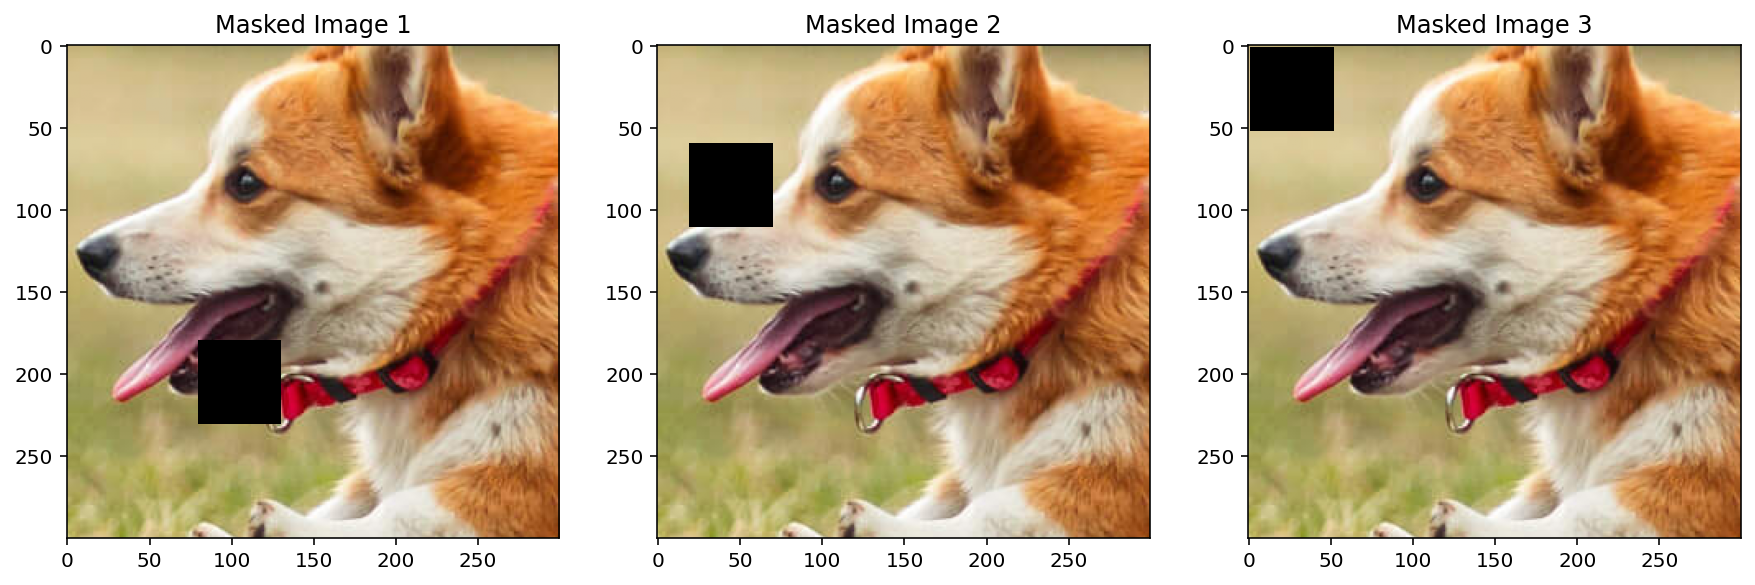

In [72]:
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(rearrange(input_img[i], 'c h w -> h w c').cpu().numpy())
    plt.title(f'Masked Image {i+1}')

In [73]:
rank = [5, 10, 25, 50]
output_img = []
for k in rank:
    def factorize(A, k, device=torch.device("cpu"), iterations=1000):
        A = A.to(device)
        W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
        H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
        optimizer_W = optim.SGD([W], lr=0.01)
        optimizer_H = optim.SGD([H], lr=0.01)
        mask = ~torch.isnan(A)

        for j in range(iterations):
            for i in range(100):
                diff_matrix = torch.mm(W, H) - A
                diff_matrix[~mask] = 0
                loss_H = torch.norm(diff_matrix)

                optimizer_H.zero_grad()
                loss_H.backward()
                optimizer_H.step()

            for i in range(100):
                diff_matrix = torch.mm(W, H) - A
                diff_matrix[~mask] = 0
                loss_W = torch.norm(diff_matrix)

                optimizer_W.zero_grad()
                loss_W.backward()
                optimizer_W.step()

        return W, H, loss_W + loss_H
    
    for b in range(3):
        c1 = input_img[b]
        cR1 = c1[0].clone()
        cG1 = c1[1].clone()
        cB1 = c1[2].clone()
        WR1, HR1, loss_R1 = factorize(cR1, k=100, device=device, iterations=100)
        WG1, HG1, loss_G1 = factorize(cG1, k=100, device=device, iterations=100)
        WB1, HB1, loss_B1 = factorize(cB1, k=100, device=device, iterations=100)
        RR1 = torch.mm(WR1,HR1)
        GG1 = torch.mm(WG1,HG1)
        BB1 = torch.mm(WB1,HB1)
        combined_tensor1 = torch.stack((RR1, GG1, BB1), dim=0).detach().float()
        output_img.append(combined_tensor1)    
        



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

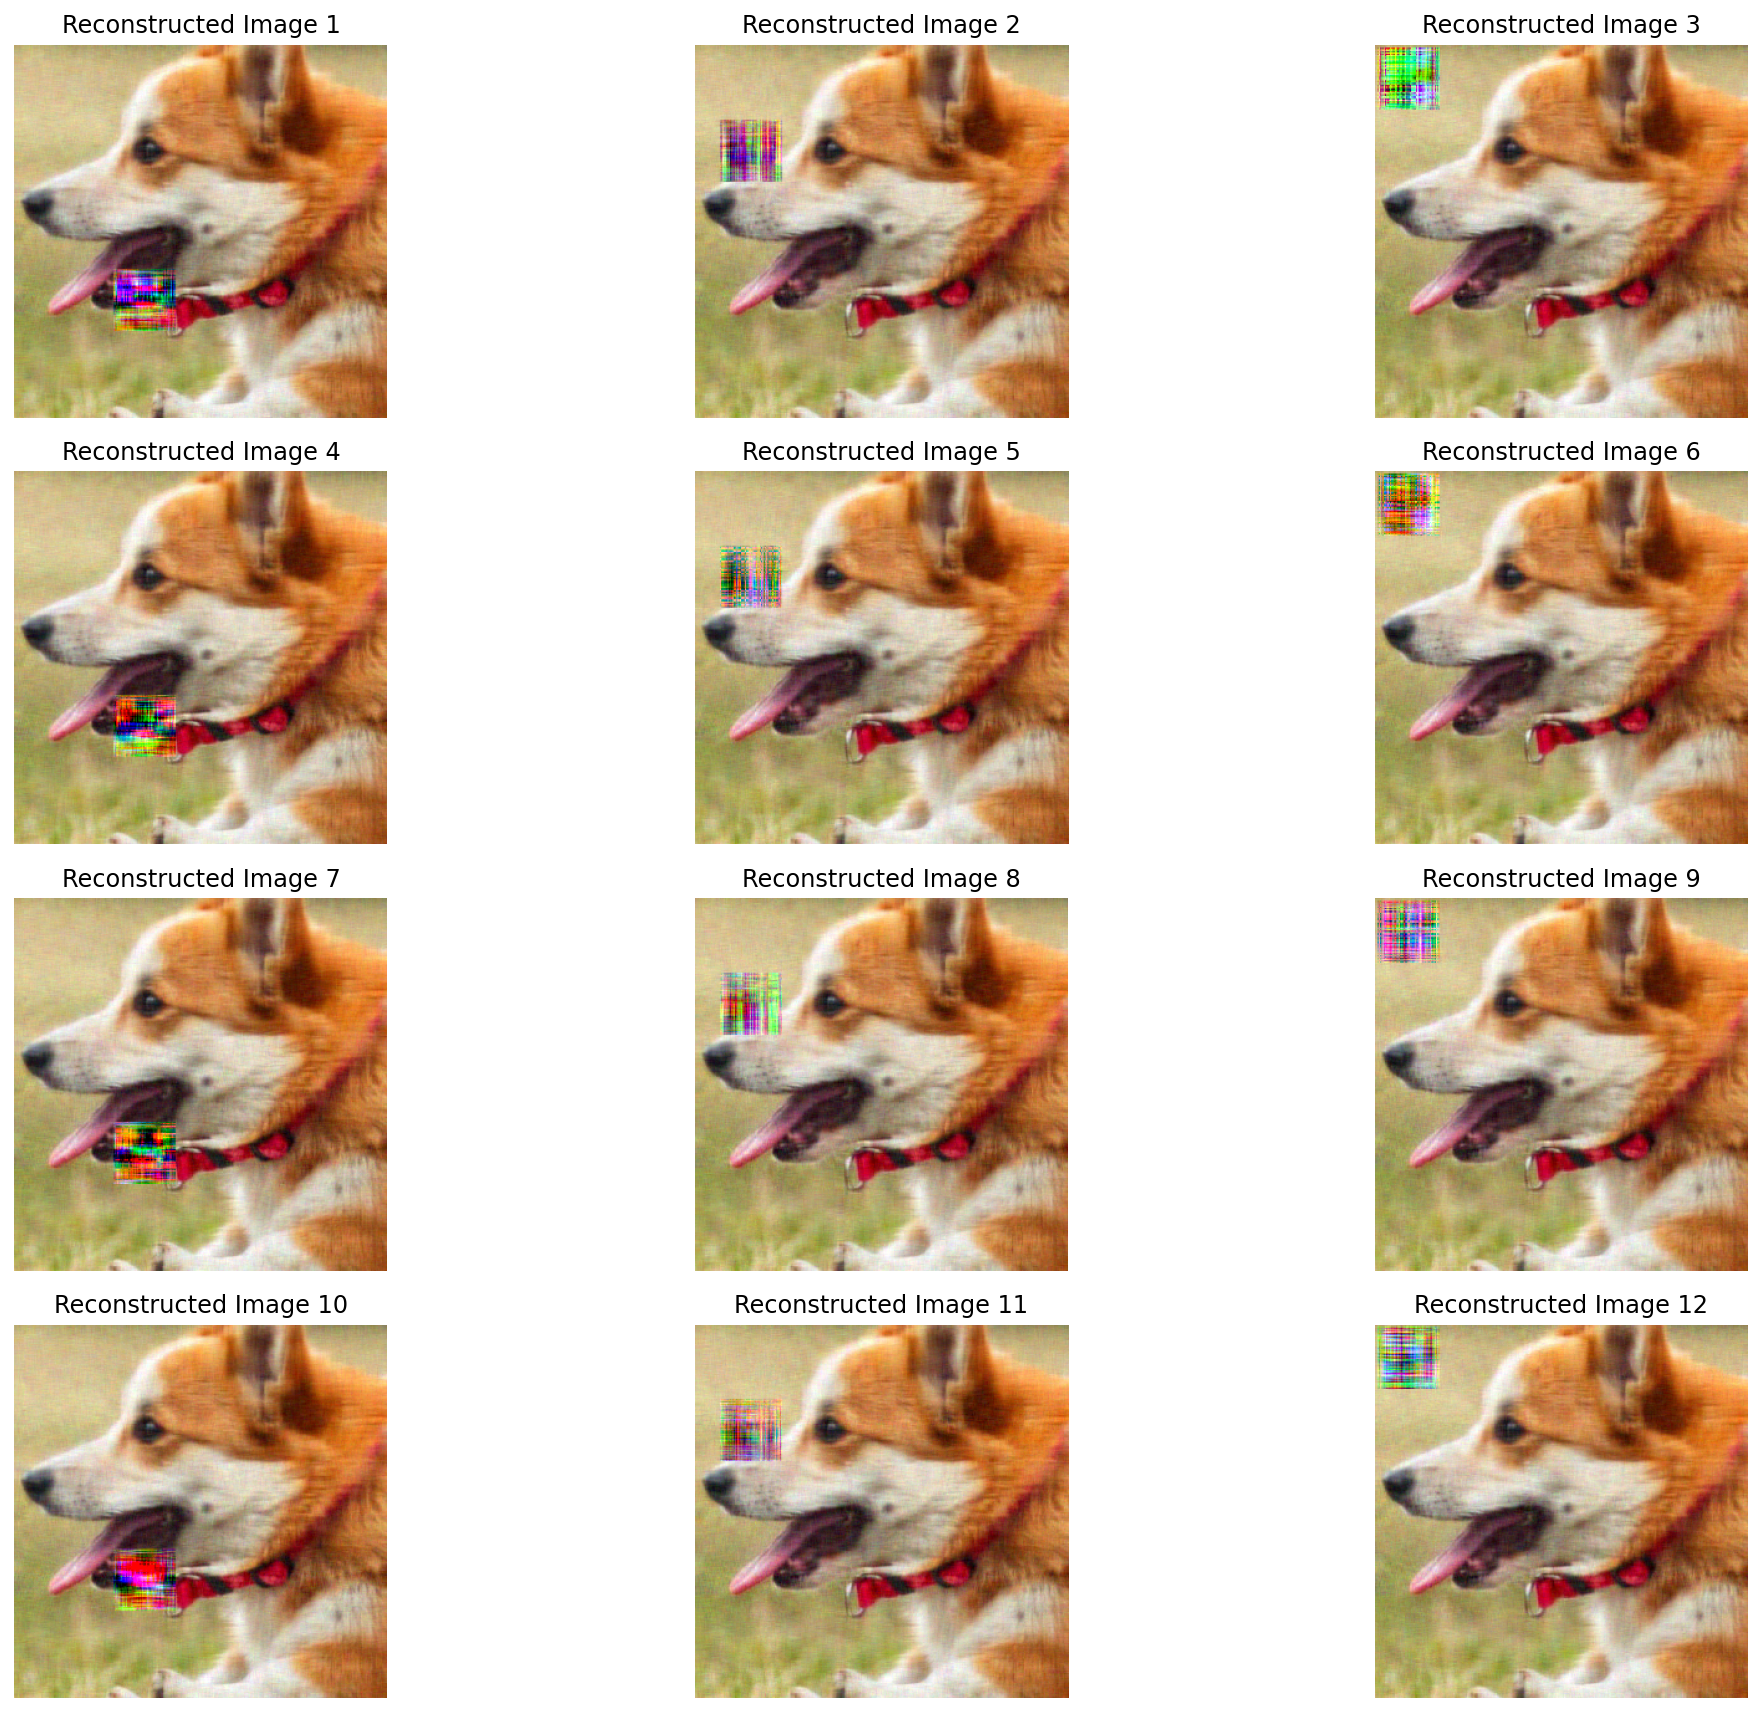

In [81]:
plt.figure(figsize=(16, 12))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(rearrange(output_img[i], 'c h w -> h w c').cpu().numpy())
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
